In [3]:
from google.colab import drive
from torchvision import datasets

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = datasets.ImageFolder('/content/drive/MyDrive/LungData/train')

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 5145
    Root location: /content/drive/MyDrive/LungData/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )

In [ ]:
test_data = datasets.ImageFolder('/content/drive/MyDrive/LungData/test')

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 1288
    Root location: /content/drive/MyDrive/LungData/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
           )

# **EDA**

In [2]:
# Import Python Package
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from PIL import Image
import plotly.offline as pyo
from IPython.display import display
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Read In Images

paths changed to visualize train/test data

In [ ]:
def read_img(path_to_main_directory):
  images = []
  for subdirectory in os.listdir(path_to_main_directory):
    subdirectory_path = os.path.join(path_to_main_directory, subdirectory)

    for filename in os.listdir(subdirectory_path):
      img_path = os.path.join(subdirectory_path, filename)
      img = cv2.imread(img_path)
      if img is not None:
        images.append(img)
  return images



In [ ]:
path_to_main_directory = '/content/drive/MyDrive/LungData/test'
images = read_img(path_to_main_directory)

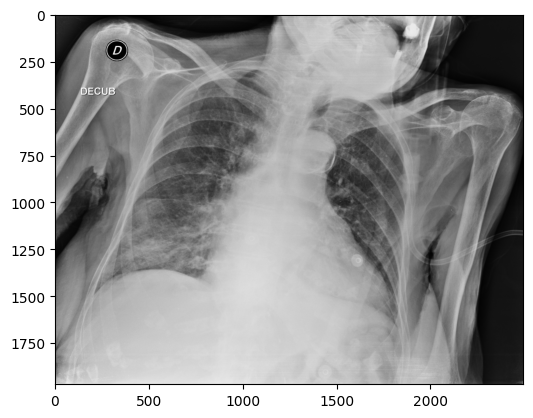

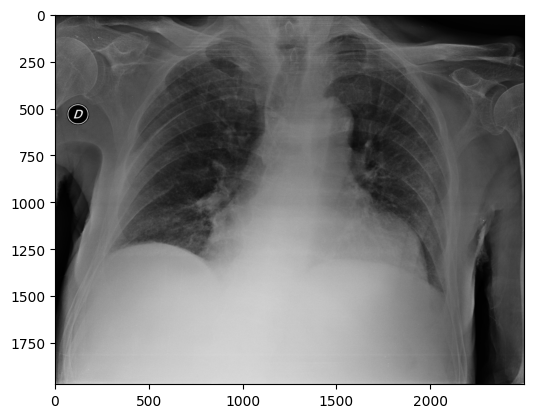

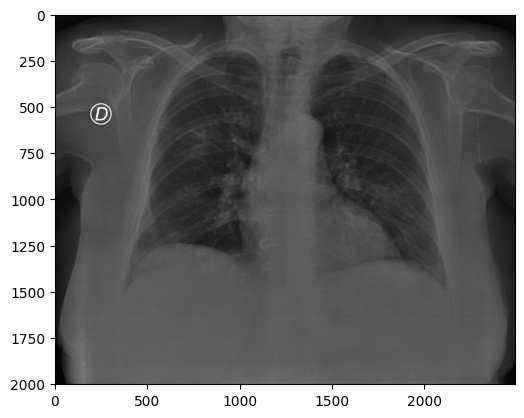

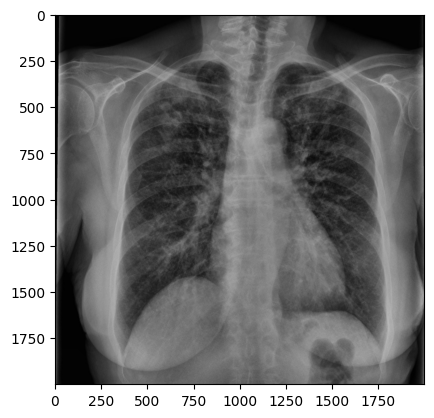

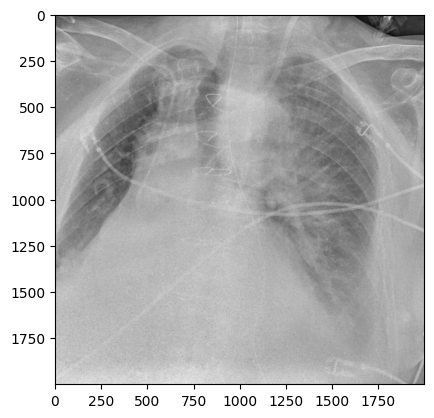

In [ ]:
for i in range(5):
  plt.imshow(images[i])
  plt.show()

# Count Images in Subdirectories

In [ ]:
def count_imgs(root_path):
  num_images = 0
  for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
      if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        num_images += 1

    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0

In [ ]:
root_path = '/content/drive/MyDrive/LungData/train'
count_imgs(root_path)

Found 0 images in directory: /content/drive/MyDrive/LungData/train
Found 1266 images in directory: /content/drive/MyDrive/LungData/train/NORMAL
Found 460 images in directory: /content/drive/MyDrive/LungData/train/COVID19
Found 3419 images in directory: /content/drive/MyDrive/LungData/train/PNEUMONIA


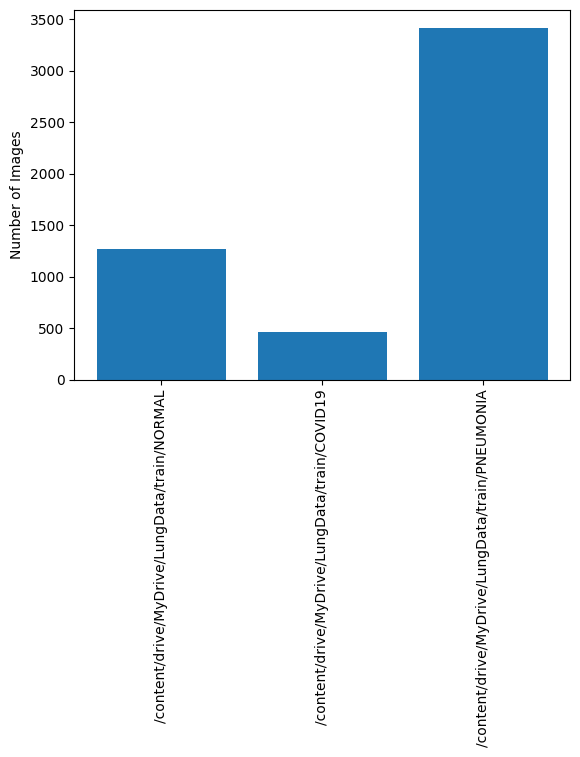

In [ ]:
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

# Distribution of Image Size, Resolution, and Color Distribution

In [ ]:
root_path = '/content/drive/MyDrive/LungData/test'

# Initialize empty lists to store the information
sizes = []
resolutions = []
color_distributions = []

# Iterate over each image file in each subdirectory
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image file using OpenCV
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path, 0)

            # Extract the size of the image
            size = os.path.getsize(img_path)
            sizes.append(size)

            # Extract the resolution of the image
            resolution = img.shape[:2]
            resolutions.append(resolution)

            # Extract the color distribution of the image
            color_distribution = np.bincount(img.flatten(), minlength=256)
            color_distributions.append(color_distribution)

# Convert the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

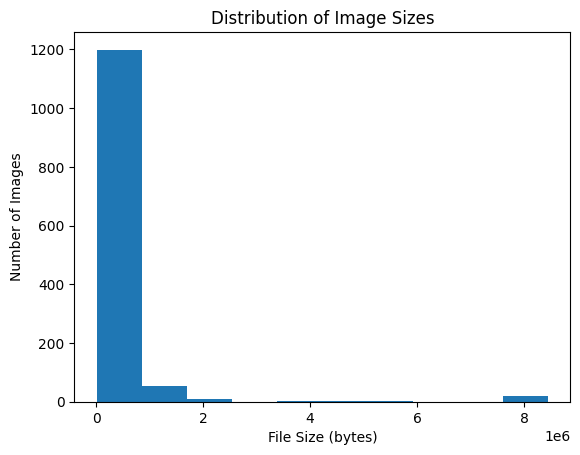

In [ ]:
# Plot a histogram of the image sizes
plt.hist(sizes)
plt.title("Distribution of Image Sizes")
plt.xlabel("File Size (bytes)")
plt.ylabel("Number of Images")
plt.show()

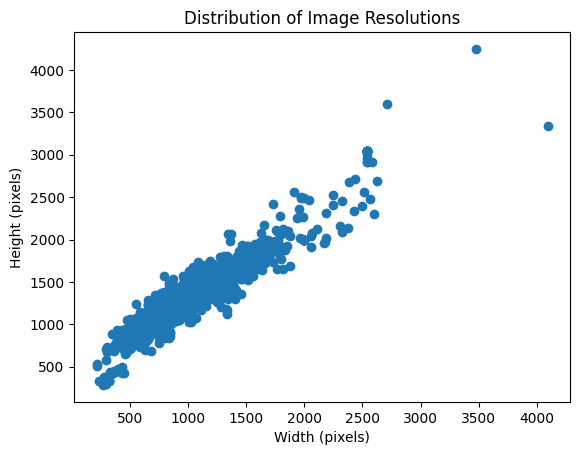

In [ ]:
# Plot a scatter plot of the image resolutions
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

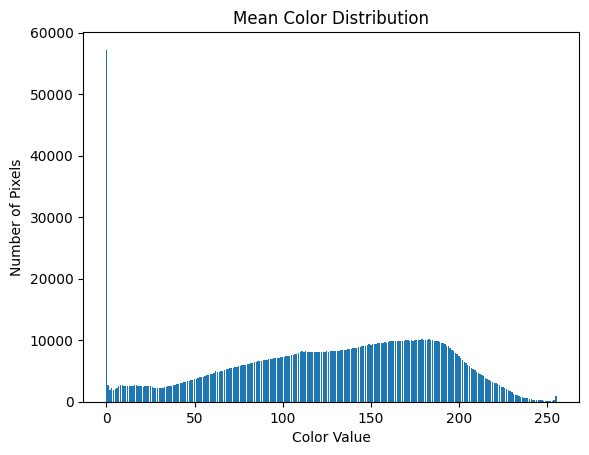

In [ ]:
# Calculate the mean color distribution across all images
mean_color_distribution = np.mean(color_distributions, axis=0)

# Plot a bar chart of the mean color distribution
plt.bar(np.arange(256), mean_color_distribution)
plt.title("Mean Color Distribution")
plt.xlabel("Color Value")
plt.ylabel("Number of Pixels")
plt.show()

# Transfer Learning Using MobileNetV2

In [ ]:
# Define transform to normalize the images
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset and split into train and test sets
trainset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/LungData/train", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/LungData/test", transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 131)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN
net = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 200}")
            running_loss = 0.0

print("Finished training")

# Evaluate the CNN on the validation set
net.eval()
total = 0
correct = 0
val_preds = []
val_labels = []
with torch.no_grad():
    for images, labels in valloader:
        # Make predictions
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.tolist())
        val_labels.extend(labels.tolist())
# Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate precision, recall, and F1 score
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")
precision = precision_score(val_labels, val_preds, average='macro')
recall = recall_score(val_labels, val_preds, average='macro')
f1 = f1_score(val_labels, val_preds, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")